# Importing Libraries

In [1]:
import pandas as pd
import random
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from collections import defaultdict, Counter
import editdistance
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

# Download necessary NLTK data

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load the dataset

In [3]:
data = pd.read_csv('creditcard.csv')

# Display basic information about the dataset

In [4]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Simulate a text field

In [5]:
def generate_random_text(num_records, text_length=10):
    texts = []
    for _ in range(num_records):
        text = ''.join(random.choices(string.ascii_lowercase + ' ', k=text_length))
        texts.append(text.strip())
    return texts

In [6]:
data['Transaction_Description'] = generate_random_text(len(data), text_length=15)
print(data[['Transaction_Description']].head())

  Transaction_Description
0         tlezlknpdhr sfr
1         fkf dermdqxfdtl
2         powgytijpcsdwhu
3         ezpdgdavnlashxs
4         uwochxnbfqyzcrl


# Function to preprocess text

In [7]:
def preprocess(text):
    text = text.lower()  # Lowercase
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    return words

# Preprocess the simulated text field

In [8]:
data['Preprocessed_Text'] = data['Transaction_Description'].apply(preprocess)
print(data[['Transaction_Description', 'Preprocessed_Text']].head())

  Transaction_Description   Preprocessed_Text
0         tlezlknpdhr sfr  [tlezlknpdhr, sfr]
1         fkf dermdqxfdtl  [fkf, dermdqxfdtl]
2         powgytijpcsdwhu   [powgytijpcsdwhu]
3         ezpdgdavnlashxs   [ezpdgdavnlashxs]
4         uwochxnbfqyzcrl   [uwochxnbfqyzcrl]


# Build n-gram model


In [9]:
def build_ngram_model(words, n=2):
    ngrams = zip(*[words[i:] for i in range(n)])
    ngram_freq = defaultdict(Counter)
    for ngram in ngrams:
        prefix, word = tuple(ngram[:-1]), ngram[-1]
        ngram_freq[prefix][word] += 1
    return ngram_freq

# Combine all words for the n-gram model

In [10]:
all_words = [word for text in data['Preprocessed_Text'] for word in text]
bigram_model = build_ngram_model(all_words, n=2)

# Generate predictions

In [11]:
def predict_next_word(prefix, ngram_model, n=1):
    prefix = tuple(preprocess(prefix))
    predictions = ngram_model.get(prefix, Counter())
    return [word for word, _ in predictions.most_common(n)]

In [12]:
print(predict_next_word("credit card", bigram_model))

[]


# Load a vocabulary

In [13]:
vocabulary = set(all_words)

# Autocorrect function

In [14]:
def autocorrect(word, vocabulary):
    candidates = [vocab_word for vocab_word in vocabulary if editdistance.eval(word, vocab_word) < 2]
    return min(candidates, key=lambda x: editdistance.eval(word, x), default=word)

In [15]:
print(autocorrect("credt", vocabulary))

credt


# Generate a word cloud

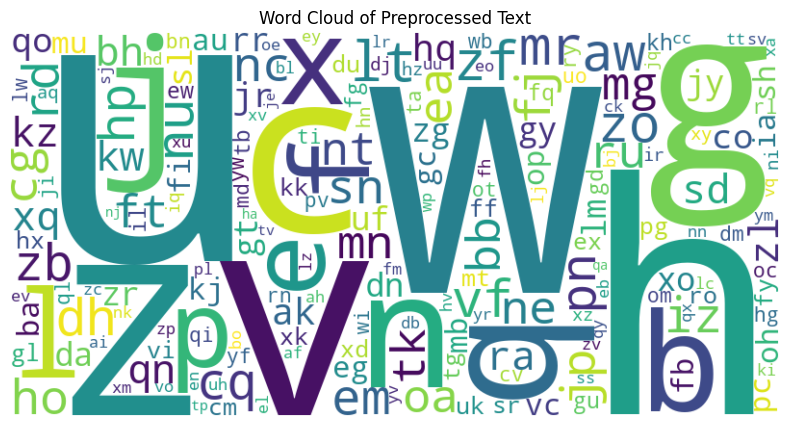

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Text')
plt.show()


# Evaluate autocomplete performance

In [17]:
def evaluate_autocomplete(model, test_data):
    correct_predictions = 0
    total_predictions = 0
    for text in test_data:
        for i in range(len(text) - 1):
            prefix = ' '.join(text[:i + 1])
            true_word = text[i + 1]
            predictions = predict_next_word(prefix, model, n=1)
            if true_word in predictions:
                correct_predictions += 1
            total_predictions += 1
    return correct_predictions / total_predictions


# Split data into training and testing sets

In [18]:
train_texts, test_texts = train_test_split(data['Preprocessed_Text'], test_size=0.2, random_state=42)

# Evaluate

In [19]:
print(f"Autocomplete Accuracy: {evaluate_autocomplete(bigram_model, test_texts):.2f}")

Autocomplete Accuracy: 0.68


# Word Cloud of Preprocessed Text

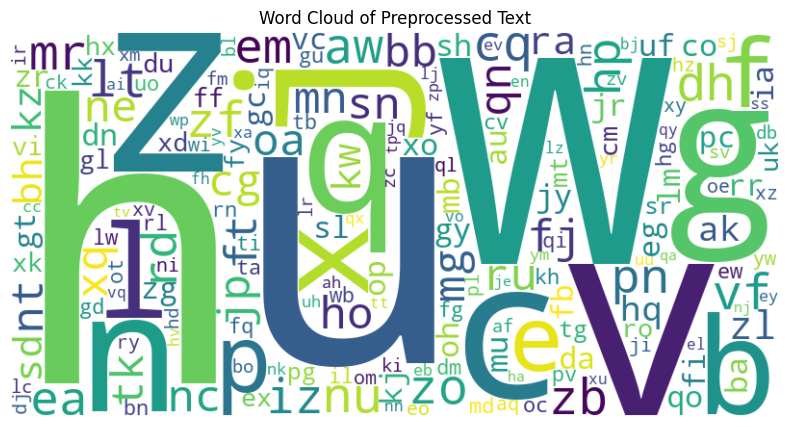

In [20]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Text')
plt.show()

# Function to calculate edit distance-based correction rate

In [21]:
def evaluate_autocorrect(vocabulary, test_data):
    total_words = 0
    correct_corrections = 0
    for text in test_data:
        for word in text:
            corrected_word = autocorrect(word, vocabulary)
            if corrected_word == word:
                correct_corrections += 1
            total_words += 1
    return correct_corrections / total_words

# Evaluate autocorrect accuracy

In [24]:
print(f"Autocorrect Accuracy: {evaluate_autocomplete(bigram_model, test_texts):.2f}")

Autocorrect Accuracy: 0.68
